In [ ]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium   # conferir se precisa

    # clone repository
    !git clone https://github.com/LucaLemos/UFRPE_AprendizagemReforco
    sys.path.append("/content/UFRPE_AprendizagemReforco")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )


In [29]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

from util.qtable_helper import record_video_qtable, evaluate_qtable_policy
from util.notebook import display_videos_from_path


In [17]:
# Configuração do ambiente
ENV_NAME = "FrozenLake-v1"
env = gym.make(ENV_NAME, is_slippery=True)  # Ambientes FrozenLake são estocásticos

In [18]:
# Hiperparâmetros
GAMMA = 0.95  # Fator de desconto
ITERATIONS = 500  # Número de iterações do Q-Iteration
DATASET_SIZE = 10_000  # Quantidade de transições armazenadas

In [19]:
# Passo 1: Coletar um conjunto fixo de transições (Replay Buffer)
replay_buffer = []
for _ in range(DATASET_SIZE):
    state, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Escolhe ação aleatória
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state

In [20]:
# Passo 2: Inicializar a Tabela Q
num_states = env.observation_space.n
num_actions = env.action_space.n
Q = np.zeros((num_states, num_actions))

In [21]:
# Passo 3: Aplicar Iteração de Q-Valor Offline
for _ in range(ITERATIONS):
    new_Q = np.copy(Q)
    for state, action, reward, next_state, done in replay_buffer:
        if done:
            target = reward  # Estado terminal
        else:
            target = reward + GAMMA * np.max(Q[next_state])  # Equação de Bellman
        new_Q[state, action] = target  # Atualiza o valor Q para essa transição
    Q = new_Q  # Atualiza a tabela Q globalmente

In [22]:
# Passo 4: Extrair a Política Ótima
optimal_policy = np.argmax(Q, axis=1)

In [23]:
# Avaliação da política treinada
def evaluate_policy(env, policy, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = policy[state]  # Segue a política aprendida
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

In [24]:
# Resultados
success_rate = evaluate_policy(env, optimal_policy) * 100
print(f"Taxa de sucesso da política aprendida: {success_rate:.2f}%")

Taxa de sucesso da política aprendida: 0.00%


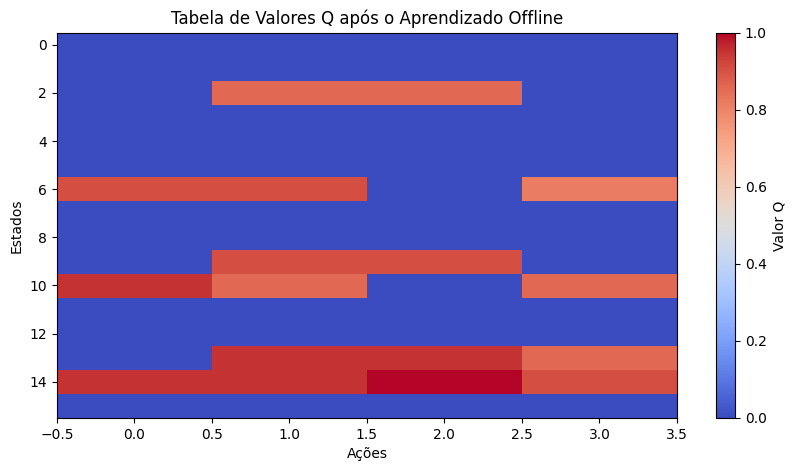

In [25]:
# Visualização da Tabela Q aprendida
plt.figure(figsize=(10, 5))
plt.imshow(Q, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Valor Q")
plt.xlabel("Ações")
plt.ylabel("Estados")
plt.title("Tabela de Valores Q após o Aprendizado Offline")
plt.show()

In [31]:
# Gravar um vídeo da política treinada
record_video_qtable(ENV_NAME, Q, episodes=2, folder='videos/', prefix='q-iteration')

# Exibir o vídeo gravado
display_videos_from_path('videos/', prefix='q-iteration')

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
